<a href="https://colab.research.google.com/github/victorbuenog/Flapper/blob/main/Flappertorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Latest changes:** Included multiple observation options to the model.

**Current issue:** Training does not work.


In [8]:
import random
import time
import pickle

import numpy
import scipy
import torch
import torch.nn as nn
from torch.distributions import Categorical

from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.path as mpath
from matplotlib.markers import MarkerStyle
import matplotlib.font_manager as fm
plt.ioff()

import gym
from gym import wrappers
from gym import spaces

import imageio

In [9]:


class InitialCondition(object):

    def __init__(self, distance=None, f2=None, A2=None, goal=None):
        self.distance = distance if distance is not None else 21.5
        self.A1 = 2.0
        self.f1 = 1.0
        self.A2 = 2.0 if A2 is None else A2
        self.f2 = 1.0 if f2 is None else f2
        self.goal = goal if goal is not None else 21.5

        self.u2 = numpy.pi * self.A1 * self.f1 * numpy.sqrt(2 * SwimmerEnv.Ct / SwimmerEnv.Cd)
        self.v2 = -self.A2*(2 * numpy.pi * self.f2)
        self.v_flow = self.A1*self.f1*numpy.cos(2*numpy.pi*self.f1*(-SwimmerEnv.dt))*numpy.exp(-SwimmerEnv.dt/SwimmerEnv.T)
        self.flow_agreement = self.v2 * self.v_flow

    def random(self, randomize_fields=[]):
        if 'distance' in randomize_fields:
            self.distance = random.uniform(10,40)
        if 'f2' in randomize_fields:
            self.f2 = random.uniform(0.5, 1.5)
        if 'A2' in randomize_fields:
            self.A2 = random.uniform(.5, 3.0)
        if 'v2' in randomize_fields:
            self.v2 = random.uniform(-1.0, 1.0)
        return self


class SwimmerEnv(gym.Env):

    s = 15.
    c = 4.
    As = s * c
    T = .5
    T = 50
    m = 80.
    Ct = .96
    Cd = .25
    rho = 1.
    dt = 0.1

    def __init__(self, action=None, observations=[], rewards=[]):
        super(SwimmerEnv, self).__init__()

        self.action_space = spaces.Discrete(3) # discrete action as 0, 1, or 2
        self.action = action  # None, 'f2', or 'A2'

        obs_low, obs_high = [], []
        if 'distance' in observations:
            obs_low.append(-numpy.inf)
            obs_high.append(numpy.inf)
        if 'f2' in observations:
            obs_low.append(0.5)
            obs_high.append(1.5)
        if 'A2' in observations:
            obs_low.append(0.5)
            obs_high.append(3.0)
        if 'flow agreement' in observations:
            obs_low.append(-numpy.inf)
            obs_high.append(numpy.inf)
        if 'velocity' in observations:
            obs_low.append(0.)
            obs_high.append(numpy.inf)

        self.observation_space = spaces.Box(low=numpy.array(obs_low), high=numpy.array(obs_high), dtype=numpy.float32)
        self.observations = observations

        self.rewards = rewards

        self.flap = None
        self.t_bound = 500.

        self.reset()

    def _shoot(self, A1, A2, f1, f2, vec_initial, t_start=0., t_bound=5000., method='RK45'):
        rho = self.rho
        As = self.As
        T = self.T
        m = self.m
        Ct = self.Ct
        Cd = self.Cd
        c = self.c

        def fun(t, vec):
            x2, u2 = vec
            u1 = numpy.pi * A1 * f1 * numpy.sqrt(2 * Ct / Cd)  # Leader velocity (constant)
            dt = -x2 / u1 + t
            Ft2 = 2*rho*As*Ct*numpy.pi**2*((A2*f2*numpy.cos(2*numpy.pi*f2*t)-A1*f1*numpy.cos(2*numpy.pi*f1*(t-dt))*numpy.exp(-dt/T)))**2
            dy_dt = (u2, (Ft2 - rho*As*Cd*u2**2/2)/m)
            return numpy.asarray(dy_dt)
        # events = [lambda t, y: y[0] - y[4] - 0.00001]
        events = []
        for ee in events: setattr(ee, 'terminal', True)
        solver = scipy.integrate.solve_ivp(fun, (t_start, t_bound), vec_initial, method=method, events=events,
                                            rtol=1e-4, atol=1e-7, max_step=.03, first_step=.001, dense_output=True)
        u1 = numpy.pi * A1 * f1 * numpy.sqrt(2 * Ct / Cd)  # Leader velocity (constant)
        x1 = u1 * solver.t[-1]  # Leader x-coord (calculated)
        y1 = A1 * numpy.sin(2 * numpy.pi * f1 * solver.t[-1])  # Leader y-coord (calculated)
        v1 = -A1*(2 * numpy.pi * f1)*numpy.cos(2 * numpy.pi * f1 * solver.t[-1])
        y2 = A2 * numpy.sin(2 * numpy.pi * f2 * solver.t[-1])  # Leader y-coord (calculated)
        v2 = -A2*(2 * numpy.pi * f2)*numpy.cos(2 * numpy.pi * f2 * solver.t[-1])
        values = list(zip(solver.t, solver.y.T))

        x2 = values[-1][1][0]
        t_tail = solver.t[-1] - (x1-x2)/u1
        v2_tail = -A2*(2 * numpy.pi * f2)*numpy.cos(2 * numpy.pi * f2 * t_tail)
        v_gradient = (v2-v2_tail)/c
        info = {
            'x1': x1,
            'y1': y1,
            'u1': u1,
            'v1': v1,
            'x2': values[-1][1][0],
            'y2': y2,
            'u2': values[-1][1][0],
            'v2': v2,
            'v_gradient': v_gradient,
        }
        return solver, values, info


    def _get_obs(self):
        obs = []
        if 'distance' in self.observations:
            obs.append(self.distance)
        if 'f2' in self.observations:
            obs.append(self.f2)
        if 'A2' in self.observations:
            obs.append(self.A2)
        if 'flow agreement' in self.observations:
            obs.append(self.flow_agreement)
        if 'velocity' in self.observations:
            obs.append(self.u2)
        obs = numpy.array(obs, dtype=numpy.float32)
        return obs


    def step(self, action):
        Ct = self.Ct
        Cd = self.Cd

        increment = (action - 1) * .1
        if self.action == 'f2':
            self.f2 = self.f2 + increment
        elif self.action == 'A2':
            self.A2 = self.A2 + increment

        t_bound_step = self.dt
        solver, values, shoot_info = self._shoot(self.A1, self.A2, self.f1, self.f2, self.flap, t_start=self.tt, t_bound=self.tt+t_bound_step)

        self.flap = values[-1][1]  # !!!
        self.tt += self.dt
        self.u1 = numpy.pi * self.A1 * self.f1 * numpy.sqrt(2 * Ct / Cd)  # Leader velocity
        self.x1 = self.u1 * self.tt  # Leader x-coord
        self.y1 = self.A1 * numpy.sin(2 * numpy.pi * self.f1 * self.tt)  # Leader y-coord
        self.y2 = self.A2 * numpy.sin(2 * numpy.pi * self.f2 * self.tt)  # Follower y-coord
        self.v1 = -self.A1*(2 * numpy.pi * self.f1)*numpy.cos(2 * numpy.pi * self.f1 * self.tt)

        v_flow = self.A1*self.f1*numpy.cos(2*numpy.pi*self.f1*(self.tt-self.dt))*numpy.exp(-self.dt/self.T)

        distance = self.x1 - self.flap[0]  # Distance between leader and follower
        done = False
        new_distance_from_goal = numpy.abs(distance - self.goal) # Distance
        new_flow_agreement = self.flap[1] * v_flow # Flow agreement
        a_flow = (v_flow-self.previous_v_flow)/self.dt # Flow acceleration
        self.u2 = (self.flap[0]-self.previous_x2)/self.dt # Follower velocity

        # Calculate average flow agreement
        self.flow_agreement_history.append(shoot_info['v2'] * v_flow)
        if len(self.flow_agreement_history) > 10:
            self.flow_agreement_history.pop(0)
        avg_flow_agreement = numpy.mean(self.flow_agreement_history)

        # Reset reward
        self.reward = 0.

        if 'distance' in self.rewards:
            self.reward += (self.distance_from_goal - new_distance_from_goal)

        if 'flow agreement' in self.rewards:
            self.reward += (new_flow_agreement - self.flow_agreement)
            # reward += new_flow_agreement

        if 'flow_acceleration' in self.rewards:
            self.reward += a_flow

        if 'velocity' in self.rewards:
            self.reward -= numpy.abs(self.u1-self.u2)

        self.previous_v_flow = v_flow
        self.distance_from_goal = new_distance_from_goal
        self.flow_agreement = new_flow_agreement
        self.previous_x2 = self.flap[0]
        self.last_reward = self.reward

        # Penalize extreme behaviors
        if distance < 0.:
            self.reward -= 100
            done = True
        elif distance > 200:
            self.reward -= 100
            done = True

        info = {
            'distance': distance,
            'action': action,
            'reward': self.reward,
            'done': done,
            'freq1': self.f1,
            'freq2': self.f2,
            'distance_from_goal': self.distance_from_goal,
            't': self.tt,
            'v_flow': v_flow,
            'a_flow': a_flow,
            'flow_agreement': self.flow_agreement,
            'u2': self.u2,
        }
        info.update(shoot_info)

        return self._get_obs(), self.reward, done, info

    def reset(self, initial_condition=None, initial_condition_fn=None):
        Ct = self.Ct
        Cd = self.Cd
        gap_distance_in_wavelengths = 1.

        # get initial condition
        if initial_condition is None:
            if initial_condition_fn is not None:
                initial_condition = initial_condition_fn()
            else:
                initial_condition = InitialCondition()

        self.A1 = initial_condition.A1
        self.f1 = initial_condition.f1
        self.A2 = initial_condition.A2
        self.f2 = initial_condition.f2
        self.goal = initial_condition.goal

        u2_initial = initial_condition.u2

        self.distance = initial_condition.distance
        self.distance_from_goal = numpy.abs(self.distance - self.goal)
        self.flow_agreement = initial_condition.flow_agreement
        self.flap = numpy.asarray([-initial_condition.distance, u2_initial])
        self.tt = 0
        self.previous_v_flow = 0
        self.flow_agreement_history = []
        self.previous_x2 = -initial_condition.distance
        self.flow_agreement = initial_condition.flow_agreement
        self.u2 = .1

        return self._get_obs()

    def render(self, mode='rgb_array'):
        fig, ax = plt.subplots()
        ax.scatter(self.x1, self.y1, label='leader')
        ax.scatter([self.flap[0]], [self.flap[1]], label='follower')
        ax.set_xlim([self.x1 - 50, self.x1 + 5])
        ax.set_ylim([-2*self.A1, 2*self.A1])
        ax.legend()
        fig.canvas.draw()
        fig.canvas.tostring_rgb()
        frame = numpy.frombuffer(fig.canvas.tostring_rgb(), dtype=numpy.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return frame

    def close(self):
        pass

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:


class Memory(object):
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, n_latent_var):
        super(ActorCritic, self).__init__()
        self.affine = nn.Linear(state_dim, n_latent_var)

        # actor
        self.action_layer = nn.Sequential(
                nn.Linear(state_dim, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, action_dim),
                nn.Softmax(dim=-1)
                )

        # critic
        self.value_layer = nn.Sequential(
                nn.Linear(state_dim, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, 1)
                )

    def forward(self):
        raise NotImplementedError

    def act(self, state, memory):
        state = torch.from_numpy(state).float().to(device)
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        action = dist.sample()

        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(dist.log_prob(action))

        return action.item()

    def evaluate(self, state, action):
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()

        state_value = self.value_layer(state)

        return action_logprobs, torch.squeeze(state_value), dist_entropy

class PPO(object):
    def __init__(self, state_dim, action_dim, n_latent_var, lr, betas, gamma, K_epochs, eps_clip):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs

        self.policy = ActorCritic(state_dim, action_dim, n_latent_var).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)
        self.policy_old = ActorCritic(state_dim, action_dim, n_latent_var).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()

    def update(self, memory):
        # Monte Carlo estimate of state rewards:
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards:
        rewards = torch.tensor(rewards).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        rewards = rewards.type(torch.float32)

        # convert list to tensor
        old_states = torch.stack(memory.states).to(device).detach()
        old_actions = torch.stack(memory.actions).to(device).detach()
        old_logprobs = torch.stack(memory.logprobs).to(device).detach()

        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Evaluating old actions and values :
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # Ensure state_values are float32
            state_values = state_values.type(torch.float32)

            # Finding the ratio (pi_theta / pi_theta__old):
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss:
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy

            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())


class Trainer(object):
    def __init__(self, **env_args):
        ############## Hyperparameters ##############
        self.env_name = "Flappers"
        self.env = SwimmerEnv(**env_args)
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = 3
        self.render = False
        self.solved_reward = 500         # stop training if avg_reward > solved_reward
        self.log_interval = 20           # print avg reward in the interval
        self.max_episodes = 1000        # max training episodes
        self.max_timesteps = 500       # max timesteps in one episode
        self.n_latent_var = 64           # number of variables in hidden layer
        self.update_timestep = 200    # update policy every n timesteps
        self.lr = 0.002
        self.betas = (0.9, 0.999)
        self.gamma = 0.99                # discount factor
        self.K_epochs = 4               # update policy for K epochs
        self.eps_clip = 0.2              # clip parameter for PPO
        self.random_seed = 4
        #############################################

        if self.random_seed:
            torch.manual_seed(self.random_seed)
            self.env.seed(self.random_seed)

        self.memory = Memory()
        self.ppo = PPO(self.state_dim, self.action_dim, self.n_latent_var, self.lr, self.betas, self.gamma, self.K_epochs, self.eps_clip)

    def load_model(self, model_path):
        self.ppo.policy.load_state_dict(torch.load(model_path))
        self.ppo.policy_old.load_state_dict(torch.load(model_path))

    def train(self, initial_condition=None, initial_condition_fn=None, episodes=None):

        # logging variables
        running_reward = 0
        avg_length = 0
        timestep = 0
        history = []

        # training loop
        if episodes is None:
            episodes = self.max_episodes
        for i_episode in range(1, episodes+1):
            state = self.env.reset(initial_condition=initial_condition, initial_condition_fn=initial_condition_fn)
            for t in range(self.max_timesteps):
                timestep += 1

                # Running policy_old:
                action = self.ppo.policy_old.act(state, self.memory)
                _, reward, done, info = self.env.step(action)

                # Saving reward and is_terminal:
                self.memory.rewards.append(reward)
                self.memory.is_terminals.append(done)

                # update if its time
                if timestep % self.update_timestep == 0:
                    self.ppo.update(self.memory)
                    self.memory.clear_memory()
                    timestep = 0

                running_reward += reward
                if self.render:
                    self.env.render()
                if done:
                    break

                history.append(info)

            avg_length += t

            # stop training if avg_reward > solved_reward
            if running_reward > (self.log_interval*self.solved_reward):
                print("########## Solved! ##########")
                torch.save(self.ppo.policy.state_dict(), './PPO_{}.pth'.format(self.env_name))
                break
            # save every 500 episodes
            if i_episode % 100 == 0:
                    torch.save(self.ppo.policy.state_dict(), './PPO_{}_{}.pth'.format(self.env_name,i_episode))
            # logging
            if i_episode % self.log_interval == 0:
                avg_length = int(avg_length/self.log_interval)
                running_reward = ((running_reward/self.log_interval))

                print('Episode {} \t avg length: {} \t reward: {}'.format(i_episode, avg_length, running_reward))
                running_reward = 0
                avg_length = 0

        return history

    def plot_policy(self, fa_range=None, f2_range=None, a2_range=None, d_range=None, u_range=None):
            action_choices = []

            if len(self.env.observations) == 0:
                raise ValueError("No observations provided")
            elif len(self.env.observations) == 1:
                pair = (self.env.observations[0], self.env.observations[0])
            elif len(self.env.observations) == 2:
                pair = (self.env.observations[0], self.env.observations[1])
            else:
                raise ValueError("Too many observations provided")

            ranges = {
                'flow agreement': fa_range,
                'distance': d_range,
                'f2': f2_range,
                'A2': a2_range,
                'u2': u_range
            }
            range1 = ranges[pair[0]]
            range2 = ranges[pair[1]]

            for x1 in range1:
                for x2 in range2:
                    state = numpy.array([x1, x2], dtype=numpy.float32)
                    state_tensor = torch.from_numpy(state).float().to(device)
                    with torch.no_grad():
                        action_probs = self.ppo.policy.action_layer(state_tensor).cpu().numpy()
                    action = numpy.argmax(action_probs)
                    action_choices.append((x1, x2, action))

            action_choices = numpy.array(action_choices)
            print(action_choices.shape)

            plt.figure(figsize=(12, 6))

            scatter = plt.scatter(action_choices[:, 0], action_choices[:, 1], c=action_choices[:, 2], cmap='viridis', marker='o')
            handles = [plt.Line2D([], [], color=scatter.cmap(scatter.norm(i)), marker='o', linestyle='', markersize=5, label=label)
                      for i, label in enumerate(['Reduce', 'Mantain', 'Increase'])]
            plt.legend(handles=handles, title='Chosen Action')
            plt.title(f'Chosen Action Based on State ({pair[0]} and {pair[1]})')
            plt.xlabel(pair[0])
            plt.ylabel(pair[1])
            plt.xticks(numpy.linspace(min(range1), max(range1), 11))
            plt.yticks(numpy.linspace(min(range2), max(range2), 11))
            plt.grid(True)
            plt.show()

    def test_initial_conditions(self, initial_conditions):

        initial_f2 = 1.
        max_timesteps = 500

        # plt.figure(figsize=(10, 6))
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))

        for ic in initial_conditions:
            obs = self.env.reset(initial_condition=ic)
            schooling_numbers = []
            flow_agreements = []
            flow_accerelations = []
            v_gradients = []
            for t in range(max_timesteps):
                action = self.ppo.policy.act(obs, Memory())
                obs, reward, done, info = self.env.step(action)
                schooling_number = (info['distance']-SwimmerEnv.c)/info['u1']/info['freq1']
                schooling_numbers.append(schooling_number)
                flow_agreements.append(info['flow_agreement'])
                flow_accerelations.append(info['a_flow'])
                v_gradients.append(info['v_gradient'])
                if done:
                    break

            # plt.plot(distances, label=f"Initial Distance: {ic.distance}")
            ax1.plot(schooling_numbers, label=f"Initial Distance: {ic.distance}")

            ax2.plot(flow_agreements, label=f"Initial Distance: {ic.distance}")

            ax3.plot(flow_accerelations, label=f"Initial Distance: {ic.distance}")

            ax4.plot(v_gradients, label=f"Initial Distance: {ic.distance}")

        ax1.set_xlabel('Timesteps (0.1 s)')
        ax1.set_ylabel('Schooling Number')
        ax1.set_title('Distance Between Leader and Follower for Different Initial Conditions')
        ax1.legend()
        ax1.grid(True)

        ax2.set_xlabel('Timesteps (0.1 s)')
        ax2.set_ylabel('Flow Agreement')
        # ax2.set_xlim([0, 100])
        ax2.set_title('Flow Agreement for Different Initial Conditions')
        ax2.legend()
        ax2.grid(True)

        ax3.set_xlabel('Timesteps (0.1 s)')
        ax3.set_ylabel('Flow Acceleration')
        # ax3.set_xlim([0, 100])
        ax3.set_title('Flow Acceleration for Different Initial Conditions')
        ax3.legend()
        ax3.grid(True)

        ax4.set_xlabel('Timesteps (0.1 s)')
        ax4.set_ylabel('Velocity Gradient')
        # ax4.set_xlim([0,100])
        std_vel_gradient = numpy.std(v_gradients)
        ax4.set_ylim([-3*std_vel_gradient,3*std_vel_gradient])
        ax4.set_title('Velocity Gradient for Different Initial Conditions')
        ax4.legend()
        ax4.grid(True)


        plt.tight_layout()
        plt.show()

    def animate(self, i):
        font_prop = fm.FontProperties(size=35)
        self.ax.clear()
        x_leader = self.leader_positions[i][0]
        y_leader = self.leader_positions[i][1]
        x_follower = self.follower_positions[i][0]
        y_follower = self.follower_positions[i][1]
        self.ax.set_xlim([x_leader - 50, x_leader + 5])
        self.ax.set_ylim([-1.5 * self.env.A1, 1.5 * self.env.A1])
        self.ax.scatter(x_leader, y_leader, label='leader', color='black', marker=self.fish_marker)
        self.ax.scatter(x_follower, y_follower, label='follower', color='black', marker=self.fish_marker)
        self.ax.grid(True, axis='x', color='grey')
        self.ax.set_xlabel('X Position (cm)', fontproperties = font_prop)
        self.ax.set_ylabel('Y Position (cm)', fontproperties = font_prop)
        self.ax.tick_params(axis='both', which='major', labelsize=30)
        return self.ax

    def naca_airfoil(self, code, num_points=100):
        """Generates the coordinates of a NACA 4-digit airfoil."""
        m = float(code[0]) / 100.0  # Maximum camber
        p = float(code[1]) / 10.0  # Location of maximum camber
        t = float(code[2:]) / 100.0  # Maximum thickness

        x = numpy.linspace(0, 1, num_points)
        yt = 5 * t * (0.2969 * numpy.sqrt(x) - 0.1260 * x - 0.3516 * x**2 + 0.2843 * x**3 - 0.1015 * x**4)

        if m == 0 and p == 0:
            yc = numpy.zeros_like(x)
            theta = numpy.zeros_like(x)
        else:
            yc = numpy.where(x <= p,
                            m / p**2 * (2 * p * x - x**2),
                            m / (1 - p)**2 * ((1 - 2 * p) + 2 * p * x - x**2))
            theta = numpy.arctan(numpy.gradient(yc, x))

        xu = x - yt * numpy.sin(theta)
        yu = yc + yt * numpy.cos(theta)
        xl = x + yt * numpy.sin(theta)
        yl = yc - yt * numpy.cos(theta)

        # Close the path by adding the first point to the end
        x_coords = -numpy.concatenate([xu, xl[::-1]])
        y_coords = numpy.concatenate([yu, yl[::-1]])

        return mpath.Path(numpy.column_stack([x_coords, y_coords]))

    def create_video(self):
        airfoil_path = self.naca_airfoil("0016")
        state = self.env.reset(InitialCondition(distance=30, f2=1.))

        self.fish_marker = MarkerStyle(airfoil_path, transform=mpl.transforms.Affine2D().scale(16))

        self.leader_positions = []
        self.follower_positions = []
        frame_rate = 12
        runtime = 30 # seconds

        for _ in range(frame_rate*runtime):
            action = self.ppo.policy.act(state, Memory())
            state, reward, done, info = self.env.step(action)

            self.leader_positions.append((info['x1'], info['y1']))
            self.follower_positions.append((info['x2'], info['y2']))

            if done:
                break

        fig, self.ax = plt.subplots(figsize=(21, 9))
        ani = animation.FuncAnimation(fig, self.animate, frames=len(self.leader_positions), interval=frame_rate, blit=False)

        # To save the animation as a video file:
        ani.save('swimmer_animation.mp4', writer='ffmpeg', fps=frame_rate)

        # Plot distances
        distances = [numpy.linalg.norm(numpy.array(leader_pos) - numpy.array(follower_pos))
                    for leader_pos, follower_pos in zip(self.leader_positions, self.follower_positions)]
        times = numpy.arange(len(distances)) * (1.0 / frame_rate)

        plt.figure()
        plt.plot(times, distances)
        plt.xlabel('Time (seconds)')
        plt.ylabel('Distance')
        plt.title('Distance between Leader and Follower vs. Time')
        plt.grid(True)
        plt.show()

        return;

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**MODEL CONTROL**

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainer = Trainer(
    action='A2',  # None, 'f2', or 'A2'
    observations=['A2', 'distance'],  # may contain: 'distance', 'f2', 'A2', 'flow agreement'
    rewards=['distance'],  # may contain: 'distance', 'flow agreement'
)

# train from scratch
icfn = lambda: InitialCondition().random(['A2','distance'])
hist = trainer.train(initial_condition_fn=icfn, episodes=1000)


# load from pth
# model_path = './PPO_Flappers_500_a2.pth'
# trainer.load_model(model_path)

/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Episode 20 	 avg length: 295 	 reward: -125.64016711857157


/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


KeyboardInterrupt: 

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


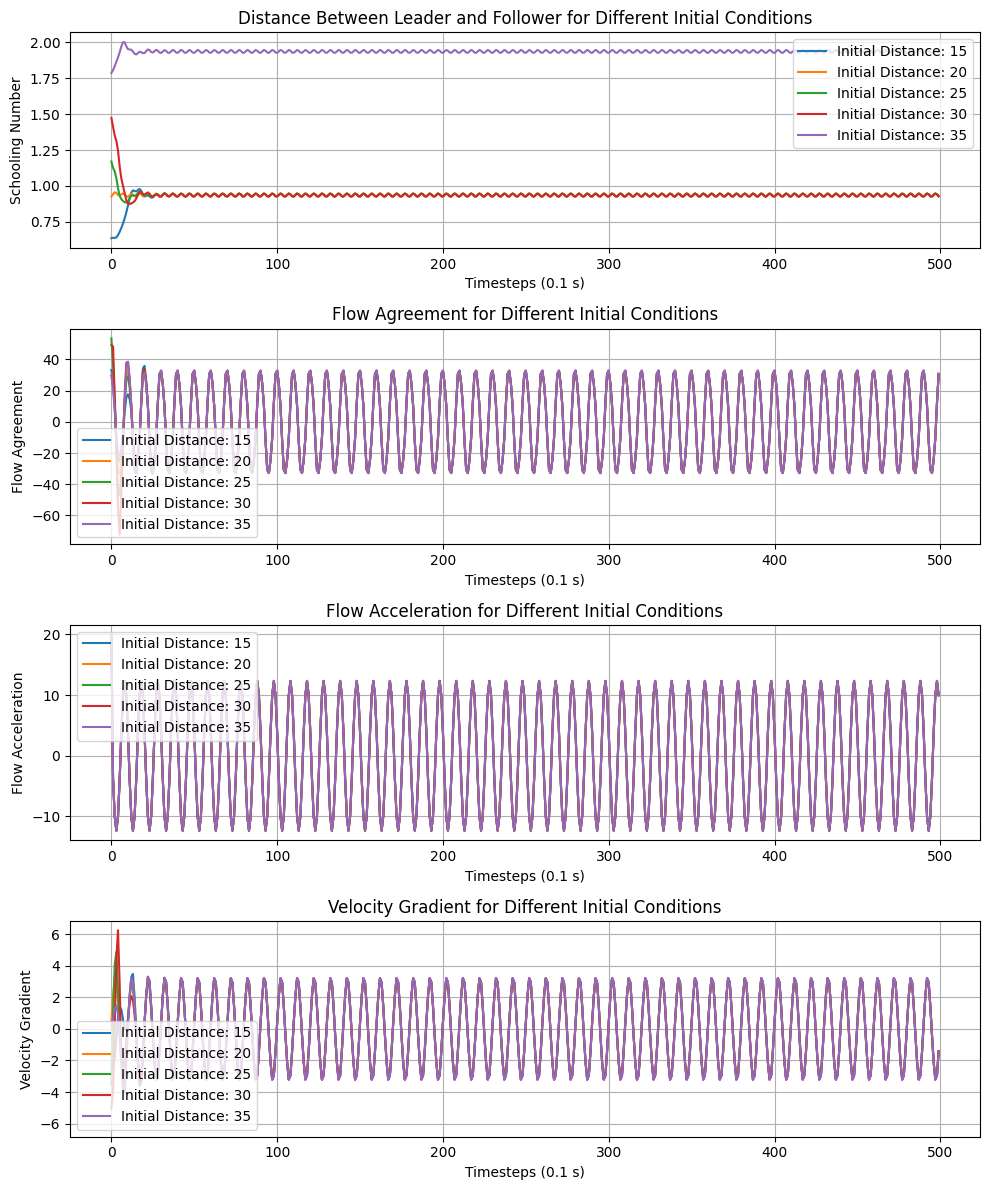

In [ ]:
trainer.test_initial_conditions(InitialCondition(distance=dd, f2=1.) for dd in range(15, 40, 5))

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(10000, 3)


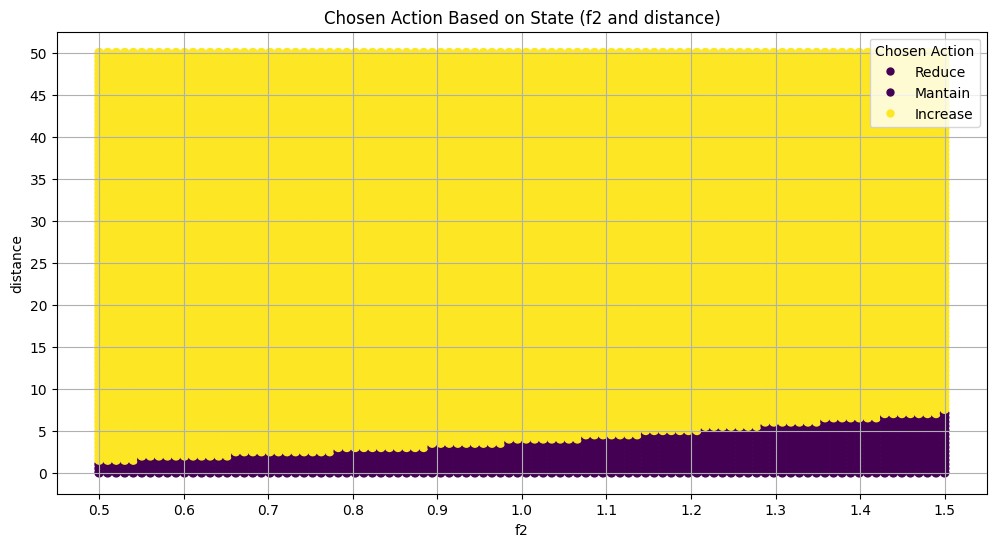

In [ ]:
# plot the policy
fa_range = numpy.linspace(-10, 10, 100)
f2_range = numpy.linspace(0.5, 1.5, 100)
a2_range = numpy.linspace(0, 3, 100)
d_range = numpy.linspace(0, 50, 100)
v_range = numpy.linspace(-10, 10, 100)
trainer.plot_policy(
    fa_range=fa_range,
    f2_range=f2_range,
    a2_range=a2_range,
    d_range=d_range,
    u_range=v_range
)

In [ ]:
# trainer.create_video()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
